# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Построим модель для задачи классификации, которая выберет подходящий тариф.
***
В качестве задачи, строим модель с максимально большим значением *accuracy*. По условию, примим во внимание минимальный уровень значения *accuracy*, 0.75. Проверим значения на тестовой выборке.
Разобьем исследование на следующие этапы:
- 1.Изучим и визуализируем данные
- 2.Разделим данные на выборки, написав ключевую функцию для раделения
- 3.Исследуем три модели решения и определим наиболее результативную, используя несколько гиперпараметров.
- 4.Проверим модель на тестовой выборке и оценим насколько модели соответствуют требуемым параметрам.
- 5.Проверим модель на адекватность,о путем сравнения их со случайной моделью.

## Откроем и изучим файл

In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

df = pd.read_csv('/datasets/users_behavior.csv')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [54]:
print(df.head())

   calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0


In [55]:
df.describe()

calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000

Итак, решаем задчу регрессии, так как у нас количественные признаки. Это задача относится к классу обучение с учителем, потому, что у нас есть целевой признак и обучающий набор данных.

Построим матрицу корреляции признаков:

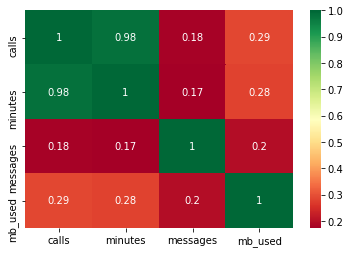

In [56]:
sns.heatmap(df[['calls', 'minutes', 'messages', 'mb_used']].corr(), cmap='RdYlGn', annot=True)
plt.show()

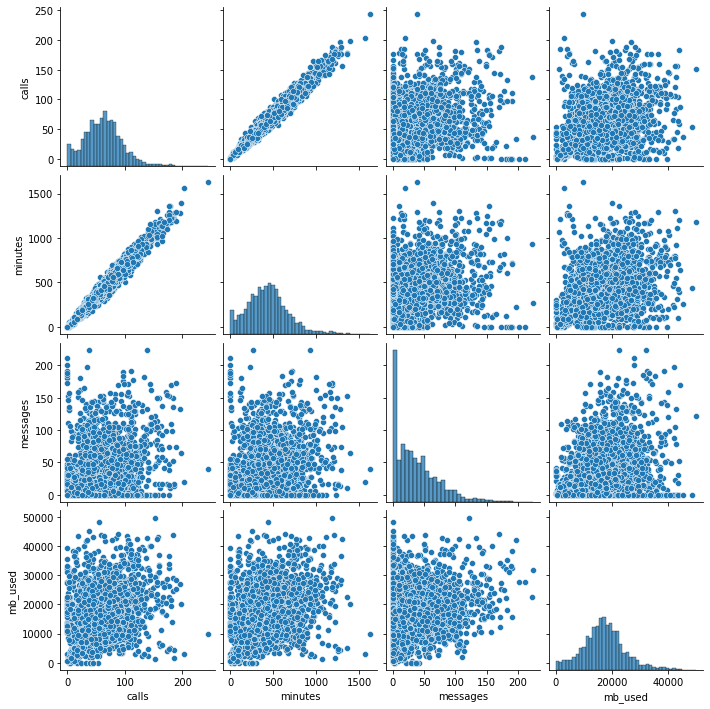

In [57]:
sns.pairplot(df[['calls', 'minutes', 'messages', 'mb_used']])
plt.show()

Мультиколлениарность обнаружилась в двух признаках - 'calls' и 'minutes'. В создании модели рекомендаций тарифного плана, потребуется только количество минут, звонков,  смс и объем трафика. Число звонков не принципиально, так как нет данных по длительности каждого звонка. Признак 'calls' можно удалить из датафрейма:

In [58]:
df = df.drop('calls', axis=1)
df.head()

minutes  messages   mb_used  is_ultra
0   311.90      83.0  19915.42         0
1   516.75      56.0  22696.96         0
2   467.66      86.0  21060.45         0
3   745.53      81.0   8437.39         1
4   418.74       1.0  14502.75         0

Посмотрим на матрицу, после устранения признака 'calls':

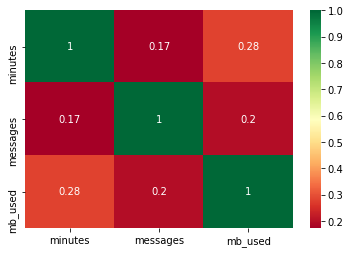

In [59]:
sns.heatmap(df[['minutes', 'messages', 'mb_used']].corr(), cmap='RdYlGn', annot=True)
plt.show()

После устранения мультиколлениарности, приступим к делению данных на выборки.

## Разобьем данные на выборки

Создадим функцию, которая разделит  датафрейм на обучающую, тестовую и валидационную выборки. По данным из нескольких источников по распределение долей, деление будет таким: обучающая выборка - 60% данных, валидационная - 20%, тестовая - 20% данных. Такое соотношение считается оптимальным, нет риска переобучения модели.

In [60]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=123):  #создадим функцию разделениея датасета на выборки
    np.random.seed(seed)                                 # вводим генератор случайных чисел
    perm = np.random.permutation(df.index)               # подключаем функцию исключения повторов для чистоты расчетов
    m = len(df.index)                                    # считаем количество элементов датафрейма
    train_end = int(train_percent * m)                   #определяем обучающую выборку
    validate_end = int(validate_percent * m) + train_end  #определяем валидационную и тестовую выборку
    train = df.iloc[perm[:train_end]]                    # Структурируем обучающую выборку
    validate = df.iloc[perm[train_end:validate_end]]     # структурируем валидационную выборку
    test = df.iloc[perm[validate_end:]]                  # структурируем тестовую выборку
    return train, validate, test                         # возвращаем результаты работы функции по выборкам

In [61]:
df_train, df_validate, df_test = train_validate_test_split(df)

In [62]:
df_train.shape[0]

1928

In [63]:
df_validate.shape[0]

642

In [64]:
df_test.shape[0]

644

Получили три выборки:

          -обучающая - 1928 объектов;
          -валидационная - 642 объекта;
          -тестовая - 644 объекта.
Создадим переменные, в котортых содержатся признаки для модели и целевые признаки.

In [65]:
#признаки модели на обучающей выборке
features_train = df_train.drop('is_ultra', axis=1)
#целевой признак
target_train = df_train['is_ultra']

#признаки модели на валидационной выборке
features_valid = df_validate.drop('is_ultra', axis=1)
#целевой признак
target_valid = df_validate['is_ultra']

#признаки модели на тестовой выборке
features_test = df_test.drop('is_ultra', axis=1)
#целевой признак
target_test = df_test['is_ultra']

In [66]:
features_train.shape[0]

1928

In [67]:
target_train.shape[0]

1928

In [68]:
features_valid.shape[0]

642

In [69]:
target_valid.shape[0]

642

In [70]:
features_test.shape[0]

644

In [71]:
target_test.shape[0]

644

## Исследуем модели

Из условия, перед нами стоит задача бинарной классификации(0 или 1). Будем рассматривать три модели решения.

- решающее дерево
- случайный лес
- логистическая регрессия

  <strong>Решающее дерево</strong>

В целях получения наибольшего значения accuracy на валидационной выборке, будем вручную менять гиперпараметры модели:

- max_depth - максимальная глубина дерева (будем рассматривать от 1 до 5, так как при глубине более 5 модель обычно переобучена)
- criterion - критерий (Джини или энтропийный)
- min_samples_split - минимальное количество объектов, необходимое для разделения внутреннего узла (от 2 до 5)
- min_samples_leaf - минимальное количество объектов в листе (от 1 до 5)

In [72]:
best_model_tree = None
best_result_tree = 0
for depth in range(1, 6):
    for criterion in ['gini', 'entropy']:
        for split in range(2, 6):
            for leaf in range(1, 6):
                model_tree = DecisionTreeClassifier(random_state=1234, max_depth=depth, criterion=criterion, \
                                                    min_samples_split=split, min_samples_leaf=leaf)
                model_tree.fit(features_train, target_train)
                predictions_tree = model_tree.predict(features_valid) 
                result_tree = accuracy_score(target_valid, predictions_tree).round(3)
                if result_tree > best_result_tree:
                    best_model_tree = model_tree
                    best_result_tree = result_tree
                 
print('Accuracy лучшей модели на валидационной выборке:', best_result_tree) 
print('Параметры лучшей модели:', best_model_tree)

Accuracy лучшей модели на валидационной выборке: 0.769
Параметры лучшей модели: DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1234)


Получили значение accuracy равное 0,769 на валидационной выборке при следующих гиперпараметрах решающего дерева:

- max_depth = 5
- criterion = entropy
- min_samples_split = 2
- min_samples_leaf = 1

<strong>Случайный лес</strong>

Рассмотрим следующую модель - случайный лес. Будем менять количество деревьев (n_estimators) от 1 до 5. Чем больше деревьев в модели, тем выше точность, но падает скорость работы.

In [73]:
best_model_forest = None
best_result_forest = 0
for est in range(1, 6):
    model_forest = RandomForestClassifier(random_state=1234, n_estimators=est) 
    model_forest.fit(features_train, target_train)
    predictions_forest = model_forest.predict(features_valid) 
    result_forest = accuracy_score(target_valid, predictions_forest).round(3)
    if result_forest > best_result_forest:
        best_model_forest = model_forest 
        best_result_forest = result_forest
        
print('Accuracy лучшей модели на валидационной выборке:', best_result_forest) 
print('Параметры лучшей модели:', best_model_forest)

Accuracy лучшей модели на валидационной выборке: 0.752
Параметры лучшей модели: RandomForestClassifier(n_estimators=4, random_state=1234)


Получили значение accuracy равное 0,752 на валидационной выборке при количестве деревьев равном 5.

<strong>Логистическая регрессия</strong>

Используем логистическую регрессию:

In [74]:
model_regress = LogisticRegression(random_state=1234, class_weight=None, solver='lbfgs') 
model_regress.fit(features_train, target_train) 
predictions_regress = model_regress.predict(features_valid)
result_regress = accuracy_score(target_valid, predictions_regress).round(3)

print("Accuracy модели логистической регрессии на валидационной выборке:", result_regress)
print('Параметры лучшей модели:', model_regress)

Accuracy модели логистической регрессии на валидационной выборке: 0.707
Параметры лучшей модели: LogisticRegression(random_state=1234)


Для логистической регрессии мы получили самое низкое значение accuracy на валидационной выборке, равное 0,707.

Теперь проверим все три модели (с подобранными гиперпараметрами) на тестовой выборке.

<div class="alert alert-info"> <b>Доработка</b></div>

Итак, сделаем короткую выборку по моделям и посмотрим на параметры лучшей:

In [84]:
data = {'validate':[best_result_tree, best_result_forest, result_regress],}
table = pd.DataFrame(data)
table.index = ['Решающее дерево', 'Случайный лес', 'Логистическая регрессия']
table

validate
Решающее дерево             0.769
Случайный лес               0.752
Логистическая регрессия     0.707

Параметры лучшей модели: DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1234)

Вывод: лучшие результаты, показала модель Решающее дерево, с количеством деревьев по гиперпараметру, равное 5ти. Это говорит о том, что "средняя температура по больнице", наиболее объективный взгляд на ситуацию

## Проверьте модель на тестовой выборке

<strong>Решающее дерево</strong>

In [75]:
predictions_test_tree = best_model_tree.predict(features_test) 
result_test_tree = accuracy_score(target_test, predictions_test_tree).round(3)
print('Accuracy модели на тестовой выборке', result_test_tree)

Accuracy модели на тестовой выборке 0.795


<strong>Случайны лес</strong>

In [76]:
predictions_test_forest = best_model_forest.predict(features_test) 
result_test_forest = accuracy_score(target_test, predictions_test_forest).round(3) 
print('Accuracy модели на тестовой выборке', result_test_forest)

Accuracy модели на тестовой выборке 0.783


<strong>Логистическая регрессия</strong>

In [77]:
predictions_test_regress = model_regress.predict(features_test)
result_test_regress = accuracy_score(target_test, predictions_test_regress).round(3)
print('Accuracy модели на тестовой выборке', result_test_regress)

Accuracy модели на тестовой выборке 0.75


In [78]:
data = {'validate':[best_result_tree, best_result_forest, result_regress], 'test':[result_test_tree, 
                                                                                   result_test_forest,
                                                                                   result_test_regress]}
table = pd.DataFrame(data)
table.index = ['Решающее дерево', 'Случайный лес', 'Логистическая регрессия']
table

validate   test
Решающее дерево             0.769  0.795
Случайный лес               0.752  0.783
Логистическая регрессия     0.707  0.750

Лучший результат показывает решающее дерево (accuracy на тестовой выборке 0,795), случайный лес немного уступает (0,783). Логистическая регрессия показала наихудший результат (0,750).

In [79]:
table['delta'] = table['test']-table['validate']
display(table['delta'].to_frame())

delta
Решающее дерево          0.026
Случайный лес            0.031
Логистическая регрессия  0.043

На тестовой выборке подтверждается хорошая работа моделей. Посмотрев на дельту, можно сделать вывод что модель"Случайны лес" имеет наименьшее расхождение результатов. Как выяснилось, такая дельта - свидетельство предсказуемости модели. Неисключено, что нужна более тонкая настройка гиперпараметров.

## Проверим модели на адекватность

Для проверки модели на адекватность нужно сравнить модель со случайной. Создадим столбец, случайным образом заполняемый нулями и единицами:

In [80]:
df_test['is_ultra_rand'] = np.random.randint(2, size=df_test.shape[0])
df_test['is_ultra_rand'].value_counts()

/tmp/ipykernel_31/3044401495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['is_ultra_rand'] = np.random.randint(2, size=df_test.shape[0])


0    333
1    311
Name: is_ultra_rand, dtype: int64

In [81]:
df_test.head()

minutes  messages   mb_used  is_ultra  is_ultra_rand
2967   583.37      58.0  20898.57         1              0
869    482.18      40.0  11178.07         1              1
3159   200.09     102.0  27432.25         1              1
1978   350.29       6.0  22870.78         0              0
873    556.84      71.0  19869.21         0              0

Создадим переменные с целевым признаком (target_one) и "предсказаниями" случайной модели (predict_rand):

In [82]:
target_one = df_test['is_ultra']
predict_rand = df_test['is_ultra_rand']

In [83]:
result_test_check = accuracy_score(target_one, predict_rand).round(3)
print('Accuracy случайной модели:', result_test_check)

Accuracy случайной модели: 0.474


Вывод: accuracy случайной модели получилась примерно 0,47 (верояность почти 50/50). Accuracy всех наших моделей выше точности случайной модели. Это говорит об адекватности обученных моделей. 

<h2>Вывод:</h2>

 Итак, в нашем распоряжении были тестовые данные и целевой признак, на базе которых мы провели эксперименты на трех моделях. Наилучший результат показала модель "решающее дерево" с результатом:

In [87]:
data = {'validate':[best_result_tree], 'test':[result_test_tree]}
table = pd.DataFrame(data)
table.index = ['Решающее дерево']
table

validate   test
Решающее дерево     0.769  0.795

Это говорит о том, что для подобного типа данных и глобально задачи регрессии, мы имеем точку отсчета в проведении дальнейших исследований по созданию корректной системы машинного обучения. Модель была опробована на случайных данных и доказала, что обучение прошло успешно.

In [89]:
print('Accuracy случайной модели:', result_test_check)

Accuracy случайной модели: 0.474


В результате, поставленная в усовии задача была выполненна!